In [1]:
#Module configuration
#from py2neo import Graph #Database connection
import neomodel
import pandas as pd
import datetime
import numpy as np
import torch
import torch.nn as nn
import random
import os

In [2]:
#Config
# Parameters :

#Structuration of the acte in the graph database -> See directly in the cell
#Nb of Embedings dimensions in Node2vec:
embeddingNbDimensions=3

#Size of the Carepath extraction
def size_of_CP_to_learn(Maxlength):
    size = Maxlength
    #size = 10
    return size

n_hidden = 10
lr=0.01
criterion = nn.MSELoss()  # Suitable loss function

#nn.NLLLoss()  nn.CrossEntropyLoss() nn.MSELoss()

myFileName='DL_Project_Dataset_Sample_V5.csv'
#'DataCP_Example/CP_Category_1.csv'
#DL_Project_Dataset_Sample_V5.csv
#'Dataset_Simple_V0.csv'
#'DL_Project_Dataset_LongCP_Cluster1-772Patients.csv'
renew_database=True


In [3]:
from neomodel import config

neo4jServerAdress = "172.19.144.105"
neo4jConnectionPort = 7687  #Connection to server bolt
user= "neo4j" 
password= "Mypassword%2023"
config.DATABASE_URL='bolt://' +user + ':' + password + '@' + neo4jServerAdress + ':' + str(neo4jConnectionPort)

In [4]:
from neomodel import (config, StructuredNode, StringProperty, IntegerProperty,DateTimeProperty,
                    DateTimeFormatProperty,UniqueIdProperty, RelationshipTo,StructuredRel)

config.DATABASE_URL='bolt://' +user + ':' + password + '@' + neo4jServerAdress + ':' + str(neo4jConnectionPort)

#NIP	J_Parcours	DateDebutActe	DateFinActe	UF	Service	Phase_Parcours	Activite	Dimension_Parcours	Ref_Acte	id_Sequence	Type_Sequence	id_sejour

class FOLLOWED_BY(StructuredRel):
    #Nb_Days = IntegerProperty(index=True, default=0)
    Next_Acte_from_JP = IntegerProperty(index=True, default=0)
    NIP=StringProperty(required=False)

class Acte(StructuredNode):
    Ref_Acte = StringProperty(required=True)
    #J_Parcours=IntegerProperty(required=False)
    #Duree = IntegerProperty(required=False)
    UF = StringProperty(required=True)
    #Service = StringProperty(required=True)
    #Phase_Parcours =StringProperty(required=True)
    #Activite =StringProperty(required=True)
    #Dimension_Parcours = StringProperty(required=True)
    #Nombre_actes=IntegerProperty(required=False, default=1)     
    Carepath = RelationshipTo('Acte', 'FOLLOWED_BY', model=FOLLOWED_BY)

class Patient(StructuredNode):
    NIP = StringProperty(unique_index=True, required=True)
    J0 = StringProperty(required=True)
    J_Parcours = IntegerProperty(required=False, default=0)
    Carepath = RelationshipTo('Acte', 'BEGIN_CAREPATH_WITH', model=FOLLOWED_BY)

In [5]:
# Define the filepath of the import csvfile
file_path = os.path.join('..', '01_Datasets', myFileName)
#file_path = r'..\01_Datasets\{myFileName}'
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=';')
# Display the first few rows of the DataFrame
df


,NIP,J_Parcours,DateDebutActe,DateFinActe,UF,Service,Phase_Parcours,Activite,Dimension_Parcours,Ref_Acte,id_Sequence,Type_Sequence,id_sejour
0,N201900002,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,8532,Médecine Nucléaire,Diagnostic,TEP,Soins,FTNTP2,12513,INIT_NEW,N1771659
1,N201900002,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,8532,Médecine Nucléaire,Diagnostic,TEP,Soins,ZZQL016,12513,INIT_NEW,N1771659
2,N201900002,0,2019-01-02 00:00:00.000,2019-01-02 00:00:00.000,1001,Médecine Nucléaire,Diagnostic,TEP,Soins,FTNTP2,12513,INIT_NEW,N160017801
3,N201900002,37,2019-02-08 00:00:00.000,2019-02-08 00:00:00.000,9050,Radiothérapie,Consultation,Consultations,Soins,CS,12513,INIT_NEW,N1791270
4,N201900002,37,2019-02-08 00:00:00.000,2019-02-08 00:00:00.000,9050,Radiothérapie,Consultation,Consultations,Soins,MCS,12513,INIT_NEW,N1791270
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,1609,12809,SUIVI_LT,N2134149
1907,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,514,12809,SUIVI_LT,N2134149
1908,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,9005,12809,SUIVI_LT,N2134149
1909,N201900413,704,2020-12-08 00:00:00.000,2020-12-08 00:00:00.000,1933,Laboratoire,Diagnostic,Diagnostic,Soins,522,12809,SUIVI_LT,N2134149


In [6]:
#Function to extract information from a row
date_format = '%Y-%m-%d %H:%M:%S.%f'

def extract_data(row):
    from datetime import datetime
    acte = {
        'Jp': row.get('J_Parcours', None),
        'DDA': datetime.strptime(row.get('DateDebutActe', None), date_format),
        'DDF': datetime.strptime(row.get('DateFinActe', None), date_format),
        'Ref': row.get('Ref_Acte', None),
        'NIP': row.get('NIP', None),
        'UFname': str(row.get('UF', None)),
        'service': row.get('Service', None),
        'phase_parcours': row.get('Phase_Parcours', None).replace(" ", ""),
        'activite': row.get('Activite', None),
        'dim_parcours': row.get('Dimension_Parcours', None),
        'Sequence_id': row.get('id_Sequence', None),
        'Sequence_Type': row.get('Type_Sequence', None),
        'Sejour_id': row.get('id_sejour', None)
    }

    return acte

In [7]:
#Define a query function
def myquery(query, params=None):
    from neomodel import db
    results, meta = db.cypher_query(query, params, resolve_objects=True)
    
    
    return results, meta

In [8]:
#Append to a node tuple

def myappend(alist,value):
    if not isinstance(alist, list):
        newlist=[alist]
    else:
        newlist=alist
    newlist.append(value)

    return newlist

In [9]:
#Define a function to create a new acte 
def create_acte(myActe):
    try:
        # Check if an existing Node Acte already exists.
        existing_acte = Acte.nodes.filter(Ref_Acte=myActe['Ref'], UF=myActe['UFname']).first()

        # If YES: Return the existing Acte
        if existing_acte:
            return existing_acte

    except Acte.DoesNotExist:
        # Handle the case where the Acte node does not exist
        pass

    #IF NO : CREATE A NEW ACTE AND RETURN IT.
    new_acte=Acte(
                    Ref_Acte = myActe['Ref'],
                    #Duree = int((myActe['DDF'] - myActe['DDA']).total_seconds()),
                    #J_Parcours = myActe['Jp'],
                    UF = myActe['UFname'],
                    #Service = myActe['service'],
                    #Phase_Parcours = myActe['phase_parcours'],
                    #Activite = myActe['activite'],
                    #Dimension_Parcours = myActe['dim_parcours'],
                ).save()
    return new_acte

def update_acte(myNodeActe, myNewActe):
    
    #Check if J_Parcours is th same between NodeActe and NewActe
    #if myNodeActe.J_Parcours==myNewActe['Jp']:
    myNodeActe.Ref_Acte=myappend(myNodeActe.Ref_Acte,myNewActe['Ref'])
    myNodeActe.UF=myappend(myNodeActe.UF,myNewActe['UFname'])
    #myNodeActe.Service=myappend(myNodeActe.Service,myNewActe['service'])
    #myNodeActe.Phase_Parcours=myappend(myNodeActe.Phase_Parcours,myNewActe['phase_parcours'])
    #myNodeActe.Activite=myappend(myNodeActe.Activite,myNewActe['activite'])
    #myNodeActe.Dimension_Parcours=myappend(myNodeActe.Dimension_Parcours,myNewActe['dim_parcours'])
    #myNodeActe.Nombre_actes=myNodeActe.Nombre_actes+1
    myNodeActe.save()
        
    #else:
    #    raise (f"Error in Updating Node {myNodeActe.id}, the new Acte doesn't have the same J parcours !")

    return myNodeActe

def create_Startnode(myActe):
    startNode=Patient(
                    NIP = myActe['NIP'],
                    J0 = myActe['DDA']
                    ).save()
    return startNode


def close_Carepath(NIP,JP,Active_Node):
    #Create a specific Acte 'End of Carepath'Acte
    
    myEndActe = {
        'Jp': JP,
        #'DDA': datetime.strptime(row.get('DateDebutActe', None), date_format),
        #'DDF': datetime.strptime(row.get('DateFinActe', None), date_format),
        'Ref': 'END_CP',
        'NIP': NIP,
        'UFname': 'END_CP',
        #'service': row.get('Service', None),
        #'phase_parcours': row.get('Phase_Parcours', None).replace(" ", ""),
        #'activite': row.get('Activite', None),
        #'dim_parcours': row.get('Dimension_Parcours', None),
        #'Sequence_id': row.get('id_Sequence', None),
        #'Sequence_Type': row.get('Type_Sequence', None),
        #'Sejour_id': row.get('id_sejour', None)
    }
    
    End_acte=create_acte(myEndActe)

    #Connect this end_acte to the active Node
    Active_Node.Carepath.connect(End_acte, {'Next_Acte_from_JP': myEndActe['Jp'] ,'NIP': myEndActe['NIP'] })
    
    return None

In [10]:
if renew_database:
    #MODELIZATION 5 : 
    #NOEUDS : ACTES , DIFFERENTIATED BY PHASE PARCOURS.
    #RELATIONS : 
        # START : for the first acte
        # ACTES REALIZED BY DAY

    #INITIALISATION   #CLEAR THE DATABASE
    query="MATCH (n) DETACH DELETE n"
    myquery(query)

    Start=True
    output=True

    # Iterate over the rows of the DataFrame
    for index, row in df.iterrows():
        # Extract values from the DataFrame
        myActe = extract_data(row)

        if Start:
            #Create a new acte
            new_acte=create_acte(myActe)
            Active_Node=new_acte
            
            #Create a start node
            startNode=create_Startnode(myActe)

            #LINK THE START NODE TO THE ACTES
            startNode.Carepath.connect(new_acte)
            Start=False

            #SET THE START NODE AS THE PREVIOUS NODE
            Previous_Node=startNode

        else:
            if oldActe['NIP']!=myActe['NIP']: #Check if we are dealing with the same patient
                
                #Close the previous Carepath
                close_Carepath(oldActe['NIP'],oldActe['Jp'],Active_Node)
                
                #Create a new acte
                new_acte=create_acte(myActe)
                
                Active_Node=new_acte
                
                #Create a start node
                startNode=create_Startnode(myActe)

                #LINK THE START NODE TO THE ACTES
                startNode.Carepath.connect(new_acte)
                #SET THE START NODE AS THE PREVIOUS NODE
                Previous_Node=startNode

            else:            
                #Check if we have to change the previous node
                if myActe['Jp']!=oldActe['Jp']:
                    #Create a new acte
                    new_acte=create_acte(myActe)

                    Previous_Node=Active_Node
                    Active_Node=new_acte

                    #LINK THE ACTE TO THE PREVIOUS ONE
                    Previous_Node.Carepath.connect(new_acte, {'Next_Acte_from_JP': myActe['Jp'] ,'NIP': myActe['NIP'] })

                else:
                    #update the active node
                    new_acte=update_acte(Active_Node,myActe)
                    #Active_Nodes.append(new_acte)

        #Store the acte in a variable oldActe
        oldActe=myActe


    #We are at the last line of the file, we need to close the last carepath as well
    close_Carepath(myActe['NIP'],myActe['Jp'],Active_Node)

In [11]:
#Get the id of the EndActe
End_acte = Acte.nodes.filter(Ref_Acte='END_CP', UF='END_CP').first()


In [12]:
End_acte.element_id

# Split the string by ':' to get the parts separated by colon
parts = End_acte.element_id.split(':')

# Get the last part of the split string and then split again by ':' to extract the final portion
End_acteid = int(parts[-1].split(':')[-1])

End_acteid

210

In [13]:
#List exsiting graph in the database
from neomodel import db
query = """
CALL gds.graph.list()
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount
ORDER BY graphName ASC
"""
results = db.cypher_query(query)
results

([['Mygraph', 366, 739]], ['graphName', 'nodeCount', 'relationshipCount'])

In [14]:

#delete all existings graphs
for graph in results[0]:
    query = f"""
            CALL gds.graph.drop('{graph[0]}') YIELD graphName;
            """
    results = db.cypher_query(query)

In [15]:
#Node Embedings

#Create an in-Memory graph:
query = """
CALL gds.graph.project(
  'Mygraph',
  'Acte',
  'FOLLOWED_BY',
  {
    relationshipProperties: 'Nb_Days'
  }
)
"""
results = db.cypher_query(query)


In [16]:
# If you need to specify a number of dimension :
#CALL gds.node2vec.stream('Mygraph', {embeddingDimension: 2})
#If you don't need to specify a number of dimension:
#CALL gds.node2vec.stream('Mygraph')


#run the node2vec algorithm:
if embeddingNbDimensions==None:
    query = """
    CALL gds.node2vec.stream('Mygraph')
    YIELD nodeId, embedding
    RETURN nodeId, embedding
    """
else:
    query = f"""
    CALL gds.node2vec.stream('Mygraph', {{embeddingDimension: {embeddingNbDimensions}}})
    YIELD nodeId, embedding
    RETURN nodeId, embedding
    """

from neomodel import db
results = db.cypher_query(query)

nb_ebemdings_dimensions=len(results[0][0][1])

In [17]:
results

([[177, [-0.04037132486701012, -0.09267960488796234, -0.5169388651847839]],
  [179, [0.00605788454413414, 0.1329694241285324, -1.306023359298706]],
  [180, [0.03387109562754631, 0.19799891114234924, -2.0608127117156982]],
  [181, [0.10747508704662323, 0.1348920613527298, -2.36785626411438]],
  [182, [-0.2554920017719269, -0.763825535774231, -2.700253486633301]],
  [183, [-0.8241775631904602, -0.6676406860351562, -2.5306599140167236]],
  [184, [-0.7140088677406311, -0.6699275970458984, -2.6647934913635254]],
  [185, [-0.955970287322998, -1.1808446645736694, -3.2539658546447754]],
  [186, [-1.291363000869751, -1.0390132665634155, -2.4430644512176514]],
  [187, [-1.1992793083190918, -1.391512393951416, -2.920478105545044]],
  [188, [-1.2534846067428589, -1.1640820503234863, -2.732451915740967]],
  [189, [-0.5922950506210327, -0.03130122274160385, -1.2921916246414185]],
  [190, [-1.1112580299377441, -0.8684698343276978, -2.224785089492798]],
  [191, [-1.5111093521118164, -1.885262012481689

In [18]:
#convert the result variable into a dict
Dict_embedings = {}

for entry in results[0]:
    node_id = entry[0]
    embedding = entry[1]
    Dict_embedings[node_id] = {'Embedding': embedding}

In [19]:
#add a zero acte at index zero
Dict_embedings[0] = {'Embedding': np.zeros(nb_ebemdings_dimensions) }

In [20]:
print(f'Dict_embedings contains {len(Dict_embedings)} items with {nb_ebemdings_dimensions} embedings dimensions each' )

Dict_embedings contains 367 items with 3 embedings dimensions each


In [21]:
#GET THE LIST OF PATIENT IN THE DATABASE

query="""MATCH (n:Patient) RETURN n.NIP"""
list_of_NIPs = db.cypher_query(query)

In [22]:
len(list_of_NIPs[0])

17

In [23]:
#GET THE LIST OF NODES_ID OF THE CAREPATH OF EACH PATIENT

NIP_Carepath={}
max_Carepath_lenght=0

for i,nip in enumerate(list_of_NIPs[0],start=1):
    
    list_of_Nodes_ID=[]
    Partial_Carepath=[]

    query=f"""
        MATCH (n:Acte)-[l:FOLLOWED_BY]->(m:Acte)-[ll:FOLLOWED_BY]->(p:Acte)
        WHERE  l.NIP='{nip[0]}' AND ll.NIP='{nip[0]}'
        RETURN id(n) AS NodeID, id(m) AS RelatedNodeID , min(l.Next_Acte_from_JP) AS fromJP
        ORDER BY fromJP, NodeID
        """
    list_of_Nodes_ID = db.cypher_query(query)

    Carepath=[]
    for j,relation in enumerate(list_of_Nodes_ID[0],start=0):
        Carepath.append(relation[0])
        lastnode=relation[1]

        #Partial Carepath
        if len(Carepath)>1 :
            Partial_Carepath.append(Carepath.copy())

    #construct the list
    Carepath.append(lastnode)
    Carepath.append(End_acteid)
    
    #Partial Carepath
    Partial_Carepath.append(Carepath.copy())


    #Add the carepath to the dict
    NIP_Carepath[i]={'NIP' : nip[0], 'Carepath' : Carepath, 'SampleCareMatrix' : Partial_Carepath}
    
    #udpate the max Carepath lenght
    if max_Carepath_lenght<len(Carepath) : max_Carepath_lenght=len(Carepath)

#NIP_Carepath


In [24]:
NIP_Carepath

{1: {'NIP': 'N201900002',
  'Carepath': [177,
   179,
   180,
   181,
   182,
   183,
   184,
   185,
   185,
   186,
   187,
   188,
   189,
   190,
   186,
   191,
   192,
   193,
   194,
   195,
   196,
   197,
   197,
   198,
   199,
   197,
   200,
   189,
   188,
   201,
   186,
   202,
   189,
   203,
   200,
   204,
   205,
   206,
   207,
   208,
   209,
   210],
  'SampleCareMatrix': [[177, 179],
   [177, 179, 180],
   [177, 179, 180, 181],
   [177, 179, 180, 181, 182],
   [177, 179, 180, 181, 182, 183],
   [177, 179, 180, 181, 182, 183, 184],
   [177, 179, 180, 181, 182, 183, 184, 185],
   [177, 179, 180, 181, 182, 183, 184, 185, 185],
   [177, 179, 180, 181, 182, 183, 184, 185, 185, 186],
   [177, 179, 180, 181, 182, 183, 184, 185, 185, 186, 187],
   [177, 179, 180, 181, 182, 183, 184, 185, 185, 186, 187, 188],
   [177, 179, 180, 181, 182, 183, 184, 185, 185, 186, 187, 188, 189],
   [177, 179, 180, 181, 182, 183, 184, 185, 185, 186, 187, 188, 189, 190],
   [177, 179, 180, 1

In [25]:
#Construct the SampleMatrix to a determined dimension and fill zeros at the left when dimension isn't enought

#determine the size of X (nb of columns)
#Maximum lenght of carepath in the database
nb_columns=size_of_CP_to_learn(max_Carepath_lenght)
#nb_columns=2

#or a definite value
#nb_columns=2

#Croop the matrix to the number of column defined
for key, value in NIP_Carepath.items():
    value['SampleCareMatrix'] = [sample[-nb_columns:] for sample in value['SampleCareMatrix']]

#Add zeros at the left when the size of the sampleCareMatrix is less than to the nb of column defined
for key, value in NIP_Carepath.items():
    for sample in value['SampleCareMatrix']:
        while len(sample) < nb_columns:
            sample.insert(0, 0)

#NIP_Carepath

In [26]:
NIP_Carepath

{1: {'NIP': 'N201900002',
  'Carepath': [177,
   179,
   180,
   181,
   182,
   183,
   184,
   185,
   185,
   186,
   187,
   188,
   189,
   190,
   186,
   191,
   192,
   193,
   194,
   195,
   196,
   197,
   197,
   198,
   199,
   197,
   200,
   189,
   188,
   201,
   186,
   202,
   189,
   203,
   200,
   204,
   205,
   206,
   207,
   208,
   209,
   210],
  'SampleCareMatrix': [[0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    177,
    179],
   [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0

In [27]:

def carepath_to_tensor(carepath):
    """Convert a name into a matrix where each row one-hot encodes a character."""
    tensor = torch.zeros(len(carepath), nb_ebemdings_dimensions)
    for idx, acte in enumerate(carepath):
        tensor[idx] = torch.tensor(Dict_embedings[acte]['Embedding'])
    return tensor

In [28]:
NIP_Carepath[1]

{'NIP': 'N201900002',
 'Carepath': [177,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  185,
  186,
  187,
  188,
  189,
  190,
  186,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  197,
  198,
  199,
  197,
  200,
  189,
  188,
  201,
  186,
  202,
  189,
  203,
  200,
  204,
  205,
  206,
  207,
  208,
  209,
  210],
 'SampleCareMatrix': [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   177,
   179],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0

In [29]:
#Construct the SampleMatrix to a determined dimension and fill zeros at the left when dimension isn't enought

#determine the size of X (nb of columns)
#Maximum lenght of carepath in the database
nb_columns=size_of_CP_to_learn(max_Carepath_lenght) 
#nb_columns=2

#or a definite value
#nb_columns=2

#Croop the matrix to the number of column defined
for key, value in NIP_Carepath.items():
    value['SampleCareMatrix'] = [sample[-nb_columns:] for sample in value['SampleCareMatrix']]

#Add zeros at the left when the size of the sampleCareMatrix is less than to the nb of column defined
for key, value in NIP_Carepath.items():
    for sample in value['SampleCareMatrix']:
        while len(sample) < nb_columns:
            sample.insert(0, 0)

#NIP_Carepath

In [30]:
NIP_Carepath

{1: {'NIP': 'N201900002',
  'Carepath': [177,
   179,
   180,
   181,
   182,
   183,
   184,
   185,
   185,
   186,
   187,
   188,
   189,
   190,
   186,
   191,
   192,
   193,
   194,
   195,
   196,
   197,
   197,
   198,
   199,
   197,
   200,
   189,
   188,
   201,
   186,
   202,
   189,
   203,
   200,
   204,
   205,
   206,
   207,
   208,
   209,
   210],
  'SampleCareMatrix': [[0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    177,
    179],
   [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0

In [31]:
NIP_Carepath[1]['SampleCareMatrix'][2]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 177,
 179,
 180,
 181]

In [32]:
carepath_to_tensor(NIP_Carepath[1]['SampleCareMatrix'][2])

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
 

In [33]:
NIP_Carepath[1]['SampleCareMatrix']

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  177,
  179],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  177,
  179,
  180],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  177,
  179,
  180,
  181],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,

In [34]:
#Let's construct a function Vec_to_Node in order to construct the prevision of carepath.

#function Vec_2_node
def Vec_2_node(query_vector, embeddings):
    closest_node_id = None
    closest_distance = float('inf')
    
    for node_id, node_embedding in embeddings.items():
        embedding_vector = node_embedding['Embedding']

        query_array = np.array(query_vector)
        embedding_array = np.array(embedding_vector)

        distance = np.linalg.norm(query_array - embedding_array)  # Euclidean distance
        if distance < closest_distance:
            closest_distance = distance
            closest_node_id = node_id
            
    return closest_node_id

# Example usage
#query_vector = np.array([0.5, 0.3, -0.1])  # Example vector you want to find the node for
#closest_node_id = Vec_2_node(query_vector, Dict_embedings)


In [35]:
nb_NIP=len(NIP_Carepath)
my_NIP_indexes_list = [i for i in range(1, nb_NIP+1)]
my_NIP_indexes_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [36]:


split = 0.5

training = {}
testing = {}

print('ordered')
print(my_NIP_indexes_list)
#random.shuffle(my_NIP_indexes_list)  # Shuffle the Carepath list
print('shuffled')
print(my_NIP_indexes_list)

split_index = int(len(my_NIP_indexes_list) * split)

training_ids = my_NIP_indexes_list[:split_index]
testing_ids = my_NIP_indexes_list[split_index:]

print('training')
print(training_ids)

print('test')
print(testing_ids)


ordered
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
shuffled
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
training
[1, 2, 3, 4, 5, 6, 7, 8]
test
[9, 10, 11, 12, 13, 14, 15, 16, 17]


In [37]:
training_ids

[1, 2, 3, 4, 5, 6, 7, 8]

In [38]:
testing_ids

[9, 10, 11, 12, 13, 14, 15, 16, 17]

In [39]:
def ids_to_tensor(list_NIP_ids):
    
    Training_NIP_tensors=[]
    
    for id_NIP in list_NIP_ids:
        
        Training_tensors=[]
        for carepathsample_index in range(len(NIP_Carepath[id_NIP]['SampleCareMatrix'])):
            #print(NIP_Carepath[id_NIP]['SampleCareMatrix'][carepathsample_index])
            #print('Associated Tensor')
            tensor=carepath_to_tensor(NIP_Carepath[id_NIP]['SampleCareMatrix'][carepathsample_index])
            #print(tensor)
            Training_tensors.append(tensor)

    # Concatenate the tensors along dimension 0
    #Training_tensor = torch.stack(Training_tensors, dim=0)
        Training_NIP_tensors.append(Training_tensors)

    return Training_NIP_tensors

In [40]:
Training   = ids_to_tensor(training_ids)
Testing     = ids_to_tensor(testing_ids)

In [41]:
# Shuffle the tensor
#shuffled_indices = torch.randperm(Training.size(0))
#Training = Training[shuffled_indices]

In [42]:
len(Training)

8

In [43]:
len(Training[0])

40

In [44]:
Training[2]

[tensor([[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0

In [45]:
#From Training/Test Tensor to Input/Output

def TrainTest_to_InputOutput(CP_Tensor):
    
    # Number of elements per new tensor
    elements_per_tensor = len(CP_Tensor[0])

    # Splitting each tensor
    input_tensor = []
    output_tensor=[]
    for tensor in CP_Tensor:
        input_tensor.append(tensor[0:elements_per_tensor-1])
        output_tensor.append(tensor[1:elements_per_tensor])
    
    #Flatening input and output tensor
    Flat_input_tensor=[tensor.flatten() for tensor in input_tensor]
    Flat_output_tensor=[tensor.flatten() for tensor in output_tensor]

    return Flat_input_tensor, Flat_output_tensor


In [46]:
input,output = TrainTest_to_InputOutput(Training[2])


In [47]:
input

[tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

In [48]:
output

[tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

In [49]:
output[1]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

DEEP LEARNING ANALYSIS

When implementing your CNN for process log prediction, consider the following aspects:
    Data Representation: How will you represent your process log data as input to the CNN? This could involve encoding categorical variables, representing sequences of events, or using embeddings.
    Model Architecture: Design the architecture of your CNN, considering factors such as the number of convolutional layers, kernel sizes, dilation rates (for TCNs), pooling layers, and the overall network architecture.
    Training Procedure: Determine how you will train your CNN, including the loss function, optimization algorithm, and any regularization techniques.
    Evaluation Metrics: Decide on appropriate evaluation metrics for assessing the performance of your CNN model on the process log prediction task.

In [50]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [51]:
#RNN Parameters :

inputsize  =  (size_of_CP_to_learn(max_Carepath_lenght)-1) * nb_ebemdings_dimensions
outputsize = (size_of_CP_to_learn(max_Carepath_lenght)-1) * nb_ebemdings_dimensions


# Enable anomaly detection
#torch.autograd.set_detect_anomaly(True)

# Define Loss, Optimizer
#criterion = nn.NLLLoss()  nn.CrossEntropyLoss()
#Mean Absolute Error : nn.L1Loss
#Mean Sqarred Error : nn.MSELoss
#nn.HingeEmbeddingLoss


print(f'Input size = {inputsize} , Hidden size = {n_hidden} , Output size = {outputsize}')

Input size = 186 , Hidden size = 10 , Output size = 186


In [52]:

class RNN(nn.Module):
    "Simple RNN architecture that explicitly accepts its hidden state."
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        combined_size = input_size + hidden_size
        self.i2h = nn.Linear(combined_size, hidden_size)
        self.i2o = nn.Linear(combined_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=0)

    def forward(self, input, hidden):
        "Forward pass for a given input tensor and hidden state."
        combined = torch.cat((input, hidden))
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        #output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        "Create a new hidden state for a new name."
        return torch.zeros(self.hidden_size)


In [53]:
def train(rnn,tensor,criterion,optimizer, lr):
    hidden = rnn.init_hidden()
    rnn.zero_grad() #reset gradient computations.

    indexes=len(tensor)
    Input_tensor,Target_tensor = TrainTest_to_InputOutput(tensor)
    loss=0

    for i in range(indexes):
        #print(f'i = {i}')
        #print(f'INPUT = {Input_tensor[i]}')
        #print(f'HIDDEN = {hidden}')
        #print(f'OUTPUT = {Target_tensor[i]}')
        #print('end of itteration')

        output,hidden = rnn(Input_tensor[i],hidden)
        l= criterion(output,Target_tensor[i])
        loss += l

    loss.backward() #computes gradients

    # Calculate accuracy

    # Tweak the network's parameters slightly! (aka, teach the network!)
    #for p in rnn.parameters():
    #    p.data.add_(p.grad.data, alpha=-lr)
    optimizer.step()  # Update parameters based on gradients

    return output, loss #, accuracy

In [54]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    it=random.randint(0,len(Training)-1)
    return Training[it]

In [55]:
import time


Nb_batch_of_CP = len(Training)
#n_iters = Nb_batch_of_CP
n_iters = 1000
PRINT_EVERY = int(n_iters/50)+1
LOG_EVERY = int(n_iters/50)+1

# Keep track of losses for plotting.
current_loss = 0
all_losses = []


def time_since(since):
    """Return a pretty string with time elapsed."""
    now = time.time()
    s = now - since
    m, s = divmod(s, 60)
    return f"{int(m)}m {s:.2f}s"

rnn = RNN(inputsize, n_hidden, outputsize)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

#hidden = rnn.init_hidden()
start = time.time()

for it in range(0, n_iters):
    #print(f'batch n° {it}')
    output, loss = train(rnn, randomTrainingExample(),criterion,optimizer,lr)
    #output, loss = train(rnn, Training[it],criterion,optimizer,lr)
    current_loss += loss

    if it % LOG_EVERY == 0:

        # Print current progress.
        avg_loss = current_loss / LOG_EVERY
        print(f"{round(100 * (it+1) / n_iters,3)}% ({time_since(start)}) // Loss = {avg_loss:.4f} // Itteration : {it+1} / {n_iters}")
        
        # Save average loss for plotting.
        all_losses.append(avg_loss)
        current_loss = 0


0.1% (0m 0.03s) // Loss = 1.3080 // Itteration : 1 / 1000
2.2% (0m 0.49s) // Loss = 25.1623 // Itteration : 22 / 1000
4.3% (0m 1.00s) // Loss = 21.3560 // Itteration : 43 / 1000
6.4% (0m 1.43s) // Loss = 7.4682 // Itteration : 64 / 1000
8.5% (0m 1.89s) // Loss = 4.3731 // Itteration : 85 / 1000
10.6% (0m 2.38s) // Loss = 9.7224 // Itteration : 106 / 1000
12.7% (0m 2.83s) // Loss = 8.6665 // Itteration : 127 / 1000
14.8% (0m 3.20s) // Loss = 5.5930 // Itteration : 148 / 1000
16.9% (0m 3.62s) // Loss = 17.1186 // Itteration : 169 / 1000
19.0% (0m 4.05s) // Loss = 23.1408 // Itteration : 190 / 1000
21.1% (0m 4.47s) // Loss = 12.9097 // Itteration : 211 / 1000
23.2% (0m 4.93s) // Loss = 12.2410 // Itteration : 232 / 1000
25.3% (0m 5.36s) // Loss = 7.7543 // Itteration : 253 / 1000
27.4% (0m 5.79s) // Loss = 10.1928 // Itteration : 274 / 1000
29.5% (0m 6.30s) // Loss = 7.4209 // Itteration : 295 / 1000
31.6% (0m 6.71s) // Loss = 3.2693 // Itteration : 316 / 1000
33.7% (0m 7.15s) // Loss = 7

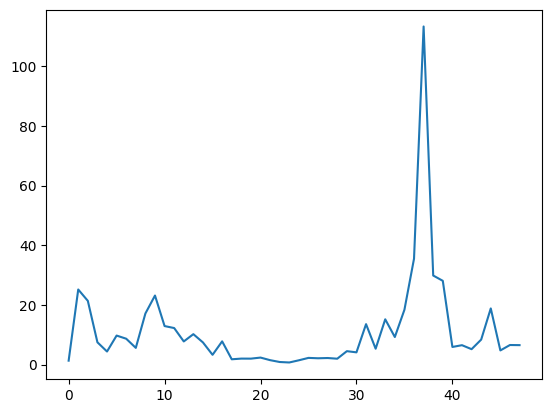

In [56]:
# Convert each tensor to a scalar
loss_list = [tensor.item() for tensor in all_losses]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_list)

https://aicontentfy.com/en/blog/step-by-step-text-generation-process-demystified

In [57]:
def Get_InputTensor_from_idNode(idNode):

    InputTensorDim = embeddingNbDimensions * (size_of_CP_to_learn(max_Carepath_lenght)-2)

    # Create an empty flat tensor of size (15,)
    Input_tensor = torch.zeros(InputTensorDim )

    #Define the star letter
    start_letter=carepath_to_tensor([idNode])
    start_letter=[tensor.flatten() for tensor in start_letter][0]

    # Append the values from star_letter tensor to the Input_tensor
    Input_tensor = torch.cat((Input_tensor, start_letter), dim=0)

    return Input_tensor

In [58]:
#PREDICT STEP
max_length = 50

# Sample from a category and starting letter
def sample(start_id):
    Predicted_Carepath=[start_id]
    with torch.no_grad():  # no need to track history in sampling
        input = Get_InputTensor_from_idNode(start_id)
        hidden = rnn.init_hidden()

        for i in range(max_length):
            output, hidden = rnn(input, hidden)
            Next_Acte=output[-3:].tolist()
            #Get the last Node from output 
            closest_node_id = Vec_2_node(Next_Acte, Dict_embedings)
            Predicted_Carepath.append(closest_node_id)
            if closest_node_id==End_acteid:
                break
            input=output

        return Predicted_Carepath

In [60]:
sample(438)

[438,
 447,
 447,
 446,
 296,
 471,
 498,
 250,
 250,
 250,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254,
 254]